# Plot 3C waveforms and PSDs of an event recorded on multiple stations 

In [231]:
# Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax, where
from pandas import read_csv, Timestamp, Timedelta
from os.path import join
from multitaper import MTSpec

from utils_basic import ROOTDIR, INNER_STATIONS_A, INNER_STATIONS_B, VELOCITY_UNIT
from utils_preproc import read_and_process_windowed_waveforms
from utils_sta_lta import read_associated_events
from utils_snuffler import read_normal_markers
from utils_cc import get_timewin_from_template_name
from utils_spec import get_disp_psd_mt

In [232]:
# Inputs
rootdir = ROOTDIR
evname = "HighB16-22-01-27"
begin = -0.05
end = 0.1

nw = 2

freqmin = 10.0
freqmax = 450.0

scale_wf = 7e-4 # scale factor for plotting the waveforms
scale_psd = 2 # scale factor for plotting the psd
scale_ax = 12 # scale factor for plotting the axes
scalebar = 500 # scale bar length in nm/s

freqs_ref = [210.0, 320.0]

linewidth_wf = 1.5
linewidth_psd = 1.5
linewidth_eb = 1
linewidth_ref = 1

fontsize_title = 15

ymax_freq_label = 1e-3
yratio_label = 1.5

In [233]:
# Read the picks
timewin = get_timewin_from_template_name(evname)
inpath = join(rootdir, timewin, f"xpicks_{evname}.dat")
pickdf = read_normal_markers(inpath)

In [234]:
# Read and process the data
stream = read_and_process_windowed_waveforms(pickdf, freqmin, freqmax, begin=begin, end=end, reference="common")
numsta = len(stream) // 3

B13


Saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-22-00-00/waveforms_and_psds_HighB16-22-01-27.png


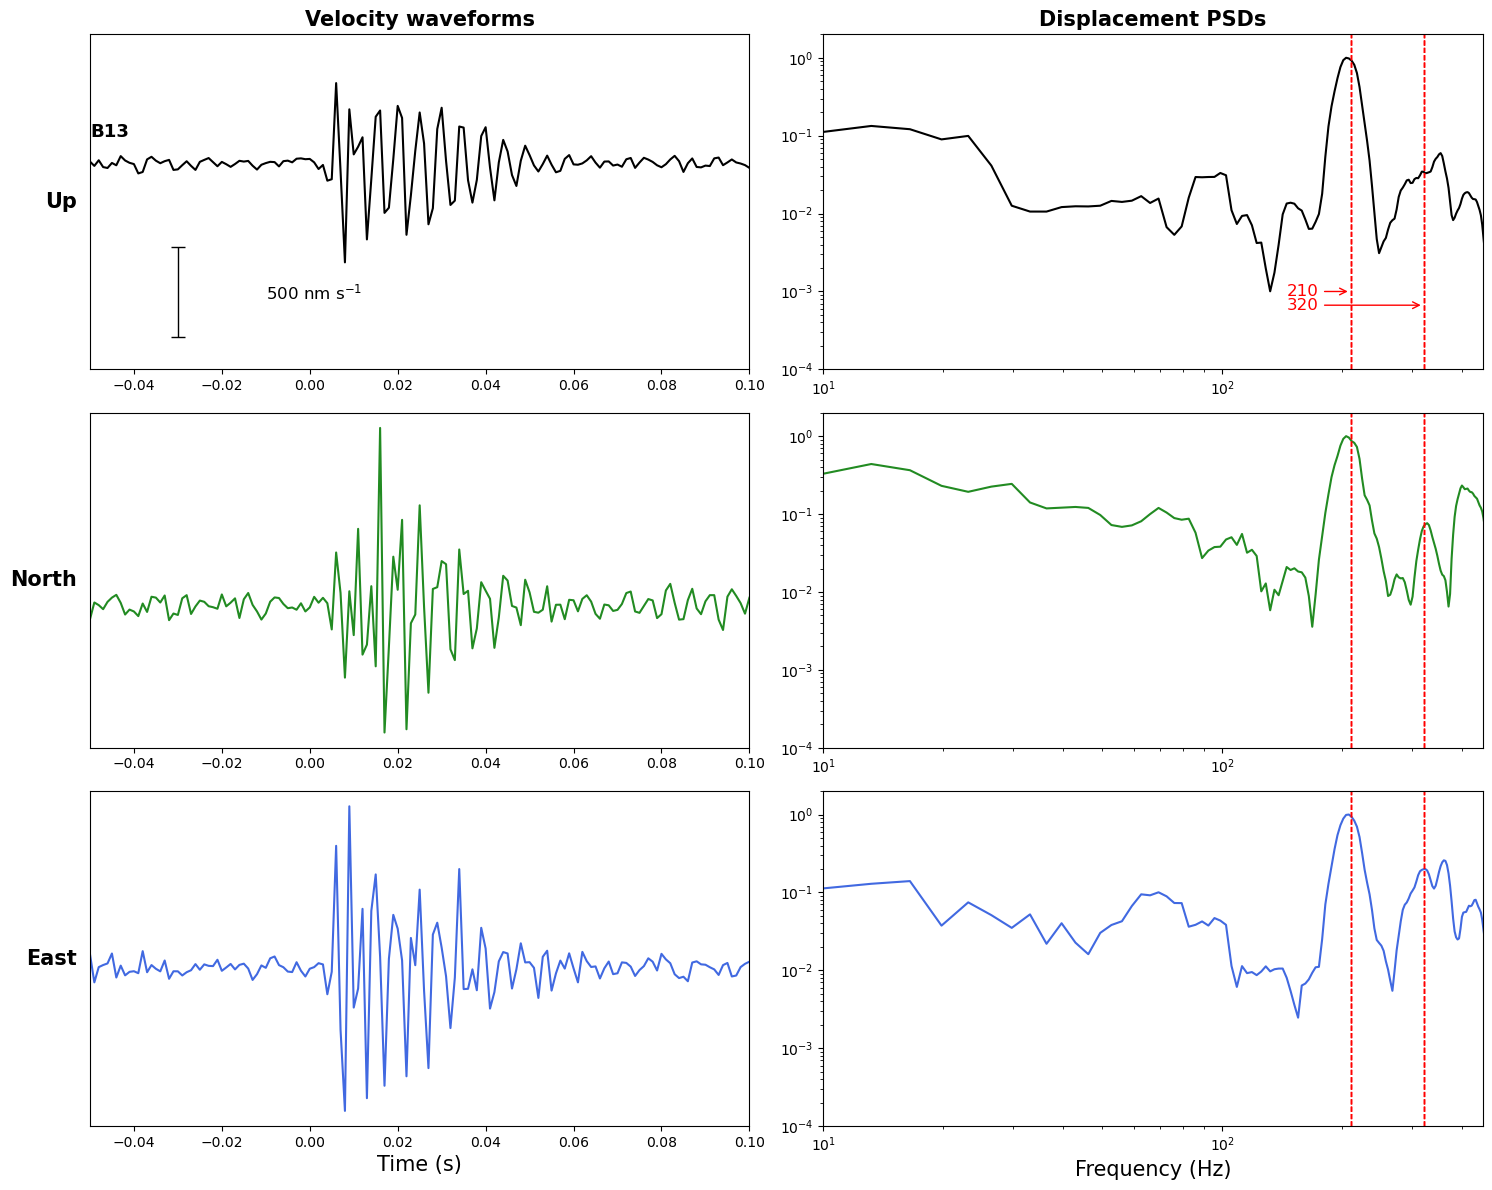

In [235]:
# Plot the waveforms and PSDs
fig, axes = subplots(nrows=3, ncols=2, figsize=(15, scale_ax*numsta))

## Loop over the stations
for i, station in enumerate(pickdf["station"]):

    ### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data
        data_1 = trace_1.data
        data_2 = trace_2.data

        sampint = trace_z.stats.delta
    except:
        print(f"Could not plot {station}")
        continue
    
    timeax = trace_z.times()+begin

    axes[0, 0].plot(timeax, data_z * scale_wf + i, color="black", linewidth=linewidth_wf)
    axes[1, 0].plot(timeax, data_1 * scale_wf + i, color="forestgreen", linewidth=linewidth_wf)
    axes[2, 0].plot(timeax, data_2 * scale_wf + i, color="royalblue", linewidth=linewidth_wf)

    axes[0, 0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=13, fontweight="bold")

    ### Compute and plot the PSDs
    freqax, psd_z = get_disp_psd_mt(data_z)
    _, psd_1 = get_disp_psd_mt(data_1)
    _, psd_2 = get_disp_psd_mt(data_2)

    psd_z = psd_z / amax(psd_z)
    psd_1 = psd_1 / amax(psd_1)
    psd_2 = psd_2 / amax(psd_2)

    axes[0, 1].loglog(freqax, psd_z, color="black", linewidth=linewidth_psd)  
    axes[1, 1].loglog(freqax, psd_1, color="forestgreen", linewidth=linewidth_psd)
    axes[2, 1].loglog(freqax, psd_2, color="royalblue", linewidth=linewidth_psd)

    ### Plot the reference frequencies
    freqref_min = amin(freqs_ref)
    for i, freq in enumerate(freqs_ref):
        axes[0, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[0, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[0, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)

        y = ymax_freq_label / (yratio_label ** i)
        axes[0, 1].annotate(f"{freq:.0f}", xy=(freq, y), xytext=(freqref_min/1.2, y), arrowprops=dict(edgecolor='red', arrowstyle="->"), fontsize=12, color="red", ha="right", va="center")

        axes[1, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[1, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[1, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)

        axes[2, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[2, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)
        axes[2, 1].axvline(x=freq, color="red", linestyle="--", linewidth=linewidth_ref)



## Plot the scale_wf bar
y_center = -0.5
time_bar = begin+0.02
axes[0, 0].errorbar(time_bar, y_center, yerr=scalebar * scale_wf/2, xerr=None, capsize=5, color='black', fmt='-', linewidth=linewidth_eb)
axes[0, 0].text(time_bar + 0.02, y_center, f"{scalebar} {VELOCITY_UNIT}", fontsize=12, va='center', ha='left')

## Set the x-axis limits
for ax in axes[:, 0]:
    ax.set_xlim([begin, end])

for ax in axes[:, 1]:
    ax.set_xlim([freqmin, freqmax])

## Set the y-axis limits
axes[0, 0].set_ylim([-0.8, numsta-0.5])

for ax in axes[:, 1]:
    ax.set_ylim([1e-4,  scale_psd])

## Label the components
axes[0, 0].text(-0.02, 0.5, "Up", fontsize=15, fontweight="bold", transform=axes[0, 0].transAxes, ha="right", va="center")
axes[1, 0].text(-0.02, 0.5, "North", fontsize=15, fontweight="bold", transform=axes[1, 0].transAxes, ha="right", va="center")
axes[2, 0].text(-0.02, 0.5, "East", fontsize=15, fontweight="bold", transform=axes[2, 0].transAxes, ha="right", va="center")

## Set titles
axes[0, 0].set_title("Velocity waveforms", fontsize=fontsize_title, fontweight="bold")
axes[0, 1].set_title("Displacement PSDs", fontsize=fontsize_title, fontweight="bold")

## Set x labels
axes[2, 0].set_xlabel("Time (s)", fontsize=15)
axes[2, 1].set_xlabel("Frequency (Hz)", fontsize=15)

## Turn off the y-axis labels and ticks
axes[0, 0].set_yticks([])
axes[1, 0].set_yticks([])
axes[2, 0].set_yticks([])

axes[0, 0].set_yticklabels([])
axes[1, 0].set_yticklabels([])
axes[2, 0].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)

## Save the figure
filename = f"waveforms_and_psds_{evname}.png"

outpath = join(ROOTDIR, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved to {outpath}")